This notebook fits a hierarchical GLM-HMM. The model includes observed discrete states $z_t \in \{1,...,N \}$, unobserved hidden states $w_t \in \{1,...,M\}$, and external inputs $u_t \in \mathbb{R}^U$. The external inputs modify the transition probabilities between the observed states according to a GLM, where the weights of the GLM depend on the hidden states. Formally, the states as generated by the following model:

$$ w_t \mid w_{t-1} \sim \text{Categorical}(\pi_{w_{t-1}}) $$

$$ z_t \mid z_{t-1}, w_t, u_t \sim \text{Categorical}(\exp(B_{w_t} u_t)+P_{z_{t-1}}) $$

where $\pi$ is the transition matrix between hidden states, $\mathbf{B}_i \in \mathbb{R}^{N \times U}, i=1,...,M$ are GLM weight matrices, and $P \in \mathbb{R}^{N \times N}$ is the baseline transition matrix between observed states. The parameters are generated by the following prior distributions:

$$ \pi \sim \text{sticky-HDP}(\gamma, \alpha, \kappa) $$

$$ B_{i,j} \sim \text{Normal}(0, \sigma_B^2)$$

$$ P_{i,j} \sim \text{Normal}(0, \sigma_P^2)$$

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax_moseq.models import glm_hmm

## Test on simulated data
In this toy example, we will simulate a simple scenario involving a robot in a 1D environment responding to a moving object $u$. The robot has 3 observable positions (left, middle, right), and two hidden states (attract and repel). The robot either moves toward or away from $u$ depending on the hidden state. Here we will simulate the case where $u$ oscillates sinusoidally. The model parameters are as follows:

- Number of observed states (positions): $N = 3$
- Number of hidden states (modes): $M = 2$
- External input dimension: $U = 1$
- Transition probabilities between the hidden states:

$$\pi = \begin{bmatrix} 0.99 & 0.01 \\ 0.01 & 0.99 \end{bmatrix}$$

- GLM weights and the baseline transition matrix:

$$B_\text{attract} = \begin{bmatrix} 1 \\ 0 \\ -1 \end{bmatrix}, \ \ \ 
  B_\text{repel} = \begin{bmatrix} -1 \\ 0 \\ 1 \end{bmatrix}, \ \ \
  P = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$$


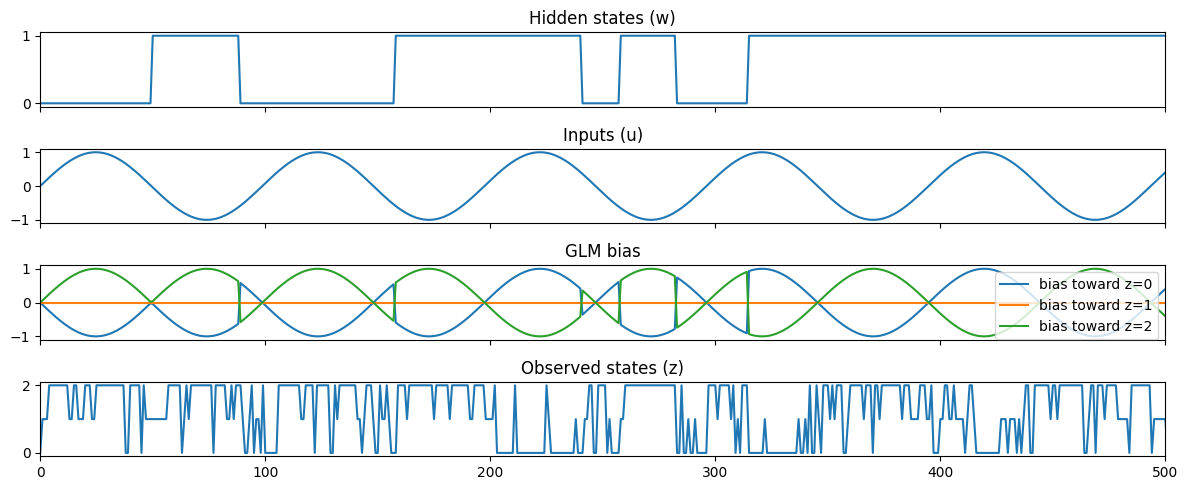

In [245]:

np.random.seed(43)

N = 3  # number of observed states
M = 2  # number of hidden states
U = 1  # external input dimension
T = 50000  # number of time steps

# Transition probabilities between hidden states
pi = np.array([[0.99, 0.01],
               [0.01, 0.99]])

# GLM weight matrices
B1 = np.array([[-1], [0], [1]])
B2 = np.array([[1], [0], [-1]])
B = np.stack([B1, B2], axis=0).astype(float)

# Baseline transition matrix between observed states
P = np.eye(3)

# External input
u = np.sin(np.arange(T)/np.pi/5)[:,na]

# Simulate hidden states
w = np.zeros(T, dtype=int)
for t in range(1, T):
    w[t] = np.random.choice(M, p=pi[w[t-1]])

# Simulate observed states
z = np.zeros(T, dtype=int)
for t in range(1, T):
    transition_prob = np.exp(B[w[t]] @ u[t] + P[z[t-1]])
    transition_prob /= transition_prob.sum()
    z[t] = np.random.choice(N, p=transition_prob)

# Plot results
fig,axs = plt.subplots(4,1,figsize=(12, 5), sharex=True)
axs[0].plot(w)
axs[1].plot(u)

glm_bias = (B[w]@(u[:,:,na])).squeeze(-1)
for i in range(N):
    axs[2].plot(glm_bias[:,i], label=f"bias toward z={i}")
axs[2].legend(loc='upper right')
axs[3].plot(z)

axs[0].set_title("Hidden states (w)")
axs[1].set_title("Inputs (u)")
axs[2].set_title("GLM bias")
axs[3].set_title("Observed states (z)")
axs[3].set_xlim([0,500])
plt.tight_layout()

### Initialize model

In [246]:
data = {'z':jnp.array(z)[na], 'mask':jnp.ones_like(z)[na], 'u':jnp.array(u)[na]}

hypparams = {
    'trans_hypparams': {
        'alpha':5, 
        'gamma':1000, 
        'kappa':100000, 
        'num_states':M
    },
    'glm_hypparams': {
        'sigmasq_B':1, 
        'sigmasq_P':1, 
        'step_size':1e-3, 
        'num_steps':10, 
        'input_dim':U, 
        'num_observed_states':N
    }
}

z,u,w,mask = jnp.array(z),jnp.array(u),jnp.array(w),jnp.array(jnp.ones_like(z))
P,B = jnp.array(P),jnp.array(B)

model = init_model(data=data, hypparams=hypparams)

### Fit model

In [248]:
for i in tqdm.trange(100): 
    model = glm_hmm.resample_model(data, **model)

100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


### Visualize results

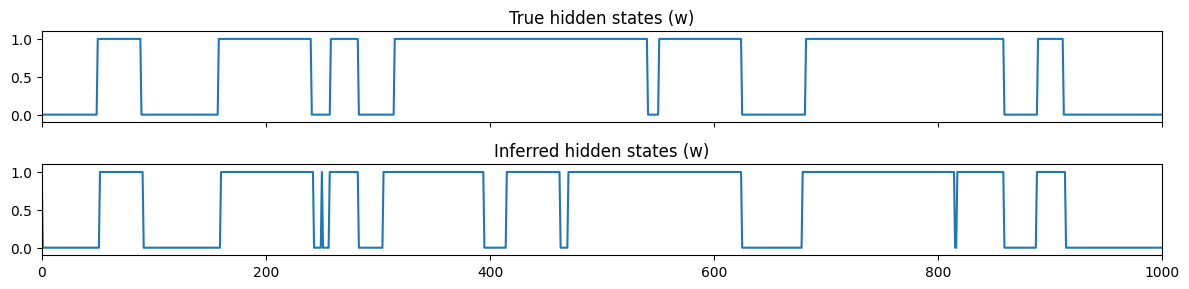

In [251]:
fig,axs = plt.subplots(2,1, figsize=(12, 3), sharex=True, sharey=True)
axs[0].plot(w)
axs[1].plot(np.array(model['states']['w'][0]))
axs[0].set_title("True hidden states (w)")
axs[1].set_title("Inferred hidden states (w)")
axs[1].set_xlim([0,1000])
axs[1].set_ylim([w.min()-.1, w.max()+.1])
plt.tight_layout()

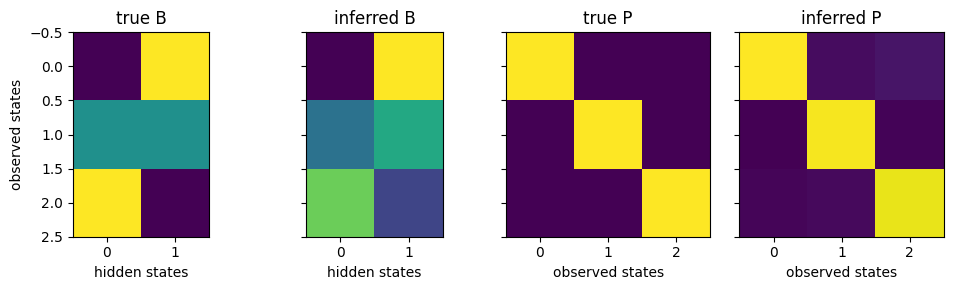

In [255]:
fig,axs = plt.subplots(1,4, figsize=(10,3), sharey=True)
axs[0].imshow(B.squeeze().T)
axs[1].imshow(np.array(model['params']['B']).squeeze().T)
axs[2].imshow(P.squeeze())
axs[3].imshow(np.array(model['params']['P']))
axs[0].set_ylabel('observed states')
axs[0].set_xlabel('hidden states')
axs[1].set_xlabel('hidden states')
axs[2].set_xlabel('observed states')
axs[3].set_xlabel('observed states')
axs[0].set_title('true B')
axs[1].set_title('inferred B')
axs[2].set_title('true P')
axs[3].set_title('inferred P')
plt.tight_layout()

In [253]:
P.shape

(3, 3)